## Problem Statement - 

An international E-commerce company (Electronic goods) wants to start their operations in India. To start with they intend to analyse the sentiments (Positive/Negative) of some of its following competitors:
* Company A
* Company B
* Company C

### Step 1: Importing Libraries

In [1]:
import os                # For interacting with operating systems
import pandas as pd      # Data Analysis
import numpy as np       # For performing mathematical operations on arrays
import matplotlib.pyplot as plt   # For Visualization
import seaborn as sns    # For Visualization    
import re                # RegEx - used to work with Regular Expressions.
import nltk              # the module is used for Natural Language processing, along with some text processing libraries for tokenisation, stemming, etc.
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import string
import snscrape.modules.twitter as sntwitter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

### Step 2: Process of extracting tweets for each competitor

##### Extracting Tweets of Competitor: Company B

tweets_compB = []


for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#compB since:2017-01-01 until:2020-12-14').get_items()):
    if i > 3500: # extracting 3500 keywords to for analysis
        break;
        
    tweets_compB.append([tweet.date, tweet.id, tweet.content])
    


df_tw_compB = pd.DataFrame(tweets_compB, columns=['Datetime', 'Tweet_Id', 'text'])

In [2]:
df_tw_compB = pd.read_csv(r'C:\Users\.................\tweet_compB.csv')

In [3]:
df_tw_compB.shape

(3501, 1)

In [4]:
df_tw_compB.head()

,text
0,Again product with missing parts &amp; not pro...
1,#FBfuel4India Join us at Facebook Fuel for Ind...
2,"@compB @compB\n#compB\nI am clarifying , My IS..."
3,@compB @Plumgoodness @compB\n#compB\nI am clar...
4,"@compB @compB\n#compB\nI am clarifying , My IS..."


##### Extracting Tweets of Competitor: Company A

In [5]:
df_tw_compA = pd.read_csv(r'C:\Users\.................\tweet_compA.csv')

In [6]:
df_tw_compA.head()

,text
0,Callas Ventilated Height Adjustable Laptop Sta...
1,[Advent calendar] What can always make you lau...
2,OneOdio Pro-10 Over Ear DJ Headphone?BLACK? [3...
3,I played #compASpinandWin on #compA #FunZone #...
4,"Callas Adjustable Portable Laptop Table, Bed T..."


In [7]:
df_tw_compA.shape

(3501, 1)

##### Extracting Tweets of Competitor: Company C

In [8]:
df_tw_compC = pd.read_csv(r'C:\Users\.................\tweet_compC.csv')

In [9]:
df_tw_compC.head()

,text
0,@compC @compC_Help @compCdiaries \nStill getti...
1,Not sure what reference citation technology yo...
2,An Engineer from Chandigarh owned iPhone 5s On...
3,Christmas Image Editing offer #backgroundremov...
4,Order your copy of my Shayari book #MuhabbatUr...


In [10]:
df_tw_compC.shape

(3501, 1)

### Step 3: Applying Text preprocessing in competitors data

##### Initializing functions which will be used for processing the tweets

In [11]:
characterMap = {u'\u00E7': 'c', u'\u00C7' : 'C', u'\u011F' : 'g', u'\u011E' : 'G', 
                u'\u00F6': 'o', u'\u00D6' : 'O', u'\u015F' : 's', u'\u015E' : 'S', 
                u'\u00FC' : 'u', u'\u00DC' : 'U' , u'\u0131' : 'i', u'\u0049' : 'I', 
                u'\u0259' : 'e', u'\u018F' : 'E'}

In [12]:
# for removing punctuations from the text.
def remove_punctuation(text):  
    text_nopunt="".join([c for c in text if c not in string.punctuation])
    return text_nopunt

In [13]:
# for removing additional punctuations and non sensical text that was missed the first time around
def clean_text_round2(text, words):
    
    text =  re.sub(r"\b[a-zA-Z]\b", "", text)
    text =  re.sub(r"\b[a-zA-Z][a-zA-Z]\b", "", text)
    text =  re.sub("[^a-zA-Z]"," ",text)# Search for all non-letters # Replace all non-letters with spaces
    text =  " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    text =  re.sub(r' +', ' ',text)
    return text

In [14]:
# for lemmatization of text
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [15]:

def stem_lemma(df,txt):
    lemmatize_text = txt
    data['text'] = df.text.apply(lemmatize_text)
    data['text'] = data.text.apply(' '.join)
    
    return data;

In [16]:
# for text preprocessing
def text_preprocessing(data):
    
    # step 1: remove ascent letters
    data['text'] = (data['text'].astype("str")
                              .str.rstrip()   ## is used to remove extra white space
                              .replace(characterMap, regex=True)
                              .str.normalize('NFKD')
                              .str.encode('ascii', errors='ignore')
                              .str.decode('utf-8'))
    
    
    # Step 2: converting to lowercase
    data.text = data.text.str.lower()
    
    # Step 3: removing URL from data
    data['text'] = data['text'].str.replace(r'http\S+|www.\S+','',case=False)
    
    # Step 4: removing punctuation
    string.punctuation
    data['text']=data['text'].apply(lambda x : remove_punctuation(x))
    
    # Step 5: Removing numbers from data
    data['text'] = data['text'].str.replace('\d+', '')
    
    # Step 6: Removing stopwords from data
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Step 7: Replacing Similar codes in the data
    nltk.download('words')
    words = set(nltk.corpus.words.words())
    round2 = lambda x: clean_text_round2(x, words)
    data = pd.DataFrame(data.text.apply(round2))
    
    # Step 8: Applying Stemming and Lemmatisation
    from nltk.stem import PorterStemmer
    nltk.download('wordnet')
    # the most commonly used stemmer
    ps = PorterStemmer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    #data = stem_lemma(data, lemmatizer)
    def lemmatize_text(text):
        return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    
    data['text'] = data.text.apply(lemmatize_text)
    data['text'] = data.text.apply(' '.join)
    
    # Step 9: Strip Extra Whitespaces
    data['text'] = (data['text'].astype("str").str.rstrip())
    
    return data;


##### Processing Tweets of Competitor: Company A

In [17]:
data_compA = text_preprocessing(df_tw_compA)
data_compA.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text
0,height adjustable stand discount
1,calendar always make laugh talent show click f...
2,pro ear discount
3,
4,adjustable portable table bed table notebook s...


##### Processing Tweets of Competitor: Company B

In [18]:
data_compB = text_preprocessing(df_tw_compB)
data_compB.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text
0,product missing providing paying service getti...
1,join fuel fuel nation take stage today ist onw...
2,issue refund cant accept pay get fud even dont...
3,issue refund cant accept pay get fud even dont...
4,issue refund cant accept pay get fud even dont...


##### Processing Tweets of Competitor: Competitor C

In [19]:
data_compC = text_preprocessing(df_tw_compC)
data_compC.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RONALD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text
0,still getting still taking action already comp...
1,sure reference citation technology rely turn g...
2,engineer see shopping
3,image offer background great discount bulk ord...
4,order copy book compilation heart touching mot...


### Step 4: Preparing Word Cloud on each competitor data

##### Document Term Matrix 

In [20]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
# preparing the document term matrix for identifying most frequent words in the collection of text
def doc_term_matrix(data):
    
    cv = CountVectorizer(stop_words='english')
    data_cv = cv.fit_transform(data.text)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

    # One of the required inputs is a term-document matrix
    tdm = data_dtm.transpose()

    tdm['freq'] = tdm.sum(axis=1)
    
    tdm.reset_index(inplace=True)
    
    tdm1=tdm[["index","freq"]]
    tdm1.rename(columns = {'index':'Word'}, inplace = True)
    tdm1.sort_values(by='freq',ascending=False,inplace=True)
    
    return tdm1;

In [22]:
# Function to plot bar-graph for visualization of most frequent words
def plot_bar(df):
    tdm1 = doc_term_matrix(df)
    
    w = tdm1[tdm1['freq'] >=150] 
    
    fg = sns.factorplot(x='Word', y='freq',
                        size=6,  aspect=2,
                        kind='bar', 
                        data=w)

In [23]:
# Function to form word-cloud on tweets collected
def plot_wordcloud(df_competitor):
    text = " ".join(review for review in df_competitor.text)
    print ("There are {} words in the combination of all review.".format(len(text)))
    

    wordcloud = WordCloud(background_color="white",max_words=2000,collocations=False).generate(text)
    plt.figure(figsize=[15,27])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

##### Word Cloud on: Company A data

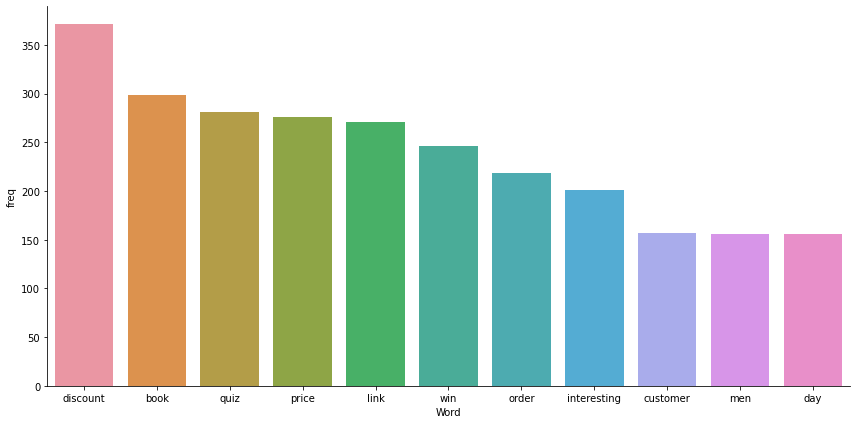

In [24]:
plot_bar(data_compA)

There are 140949 words in the combination of all review.


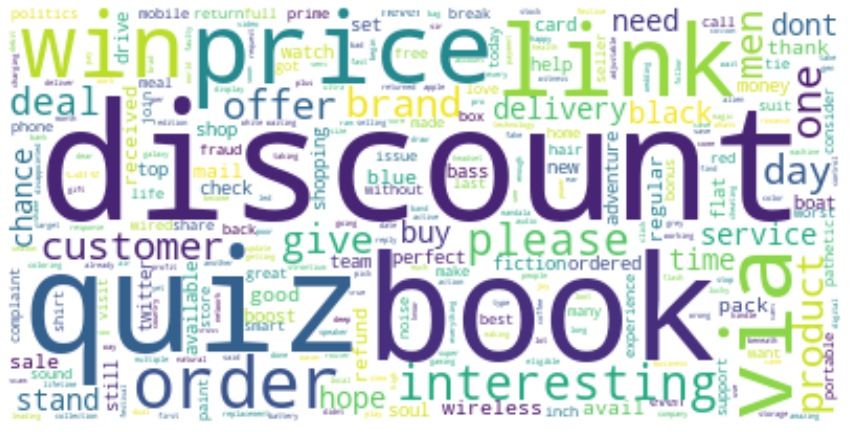

In [25]:
plot_wordcloud(data_compA)

In [26]:
freq_words=doc_term_matrix(data_compA)
freq_words.head()

,Word,freq
696,discount,371
270,book,299
1906,quiz,281
1838,price,276
1396,link,271


##### Word Cloud on: Company B data

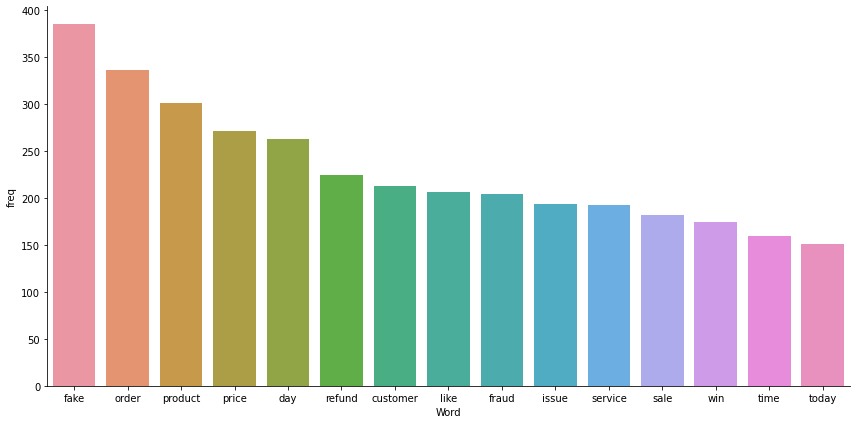

In [27]:
plot_bar(data_compB)

There are 174479 words in the combination of all review.


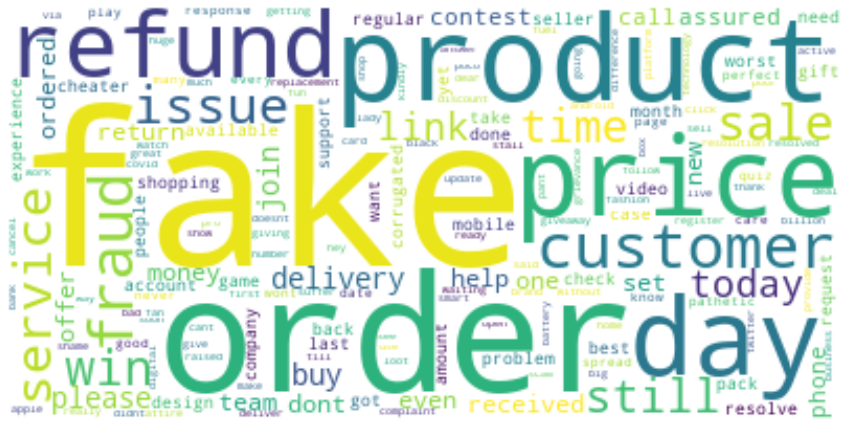

In [28]:
plot_wordcloud(data_compB)

In [29]:
freq_words_compB = doc_term_matrix(data_compB)
freq_words_compB.head()

,Word,freq
957,fake,385
1805,order,336
2011,product,301
1992,price,272
646,day,263


##### Word Cloud on : Company C Data

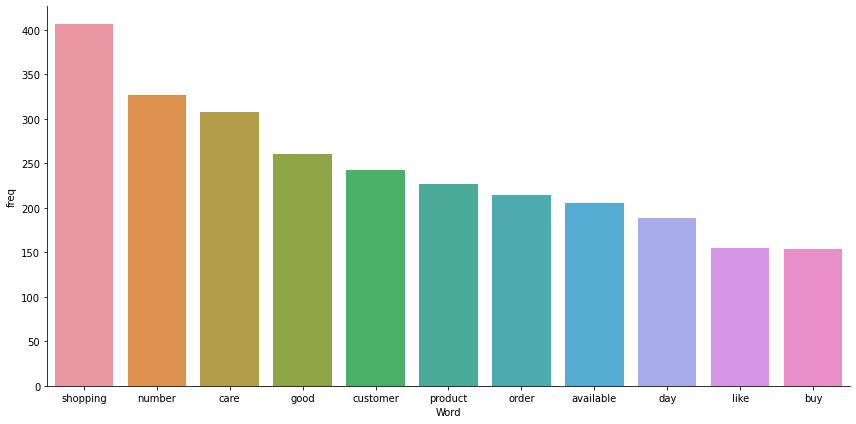

In [30]:
plot_bar(data_compC)

There are 158884 words in the combination of all review.


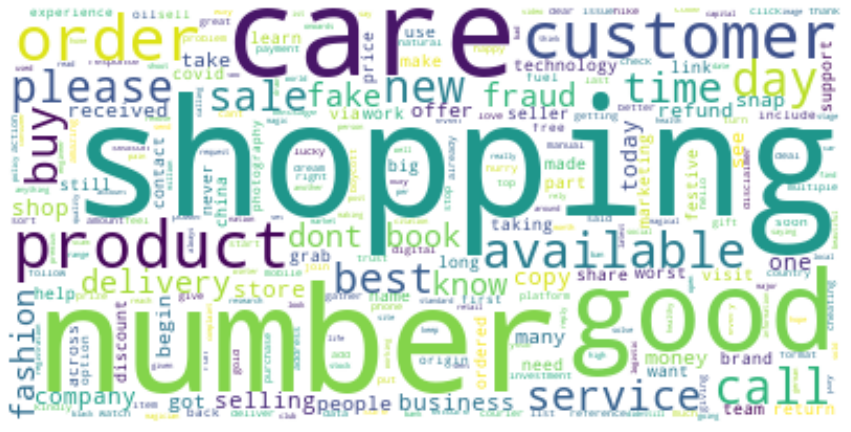

In [31]:
plot_wordcloud(data_compC)

In [32]:
freq_words_compC = doc_term_matrix(data_compC)
freq_words_compC.head()

,Word,freq
2477,shopping,406
1841,number,327
367,care,308
1213,good,260
651,customer,243


### Step 5: Sentiment Analysis on each competitor data

In [33]:
def check_sentiments(competitor_data):
    pol = lambda x: TextBlob(x).sentiment.polarity
    competitor_data['polarity'] = competitor_data['text'].apply(pol) #adding a column polarity with values
    
    #adding another column 'Sentiment' which represents the tweet being positive or negative
    competitor_data['Sentiment'] = np.where(competitor_data['polarity']>=0, 'Positive', 'Negative')     
    
    #adding another column 'Sentiment2' which represents the tweet being positive, negative and neutral
    competitor_data['Sentiment2'] = np.where(competitor_data.polarity< 0, 'Negative', np.where(competitor_data.polarity> 0,'Positive', 'Neutral'))
    
    return competitor_data;

##### On Competitor Data: Company A

In [34]:
final_data_compA = check_sentiments(data_compA)

In [35]:
final_data_compA.tail()

,text,polarity,Sentiment,Sentiment2
3496,boat wireless headphone playback adaptive disc...,0.000000,Positive,Neutral
3497,,0.000000,Positive,Neutral
3498,starting display discount,0.000000,Positive,Neutral
3499,epic journey iconic unexpected via book,0.233333,Positive,Positive
3500,money consumer grievance complaint take liability,-0.300000,Negative,Negative


In [36]:
final_data_compA.Sentiment.value_counts()

Positive    2991
Negative     510
Name: Sentiment, dtype: int64

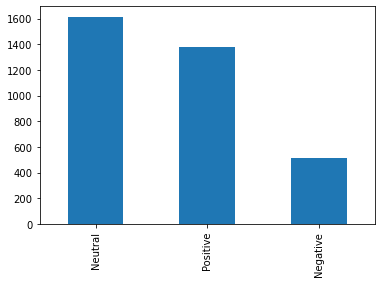

In [37]:
final_data_compA.Sentiment2.value_counts().plot.bar()

In [38]:
final_data_compA.Sentiment2.value_counts()

Neutral     1613
Positive    1378
Negative     510
Name: Sentiment2, dtype: int64

Company A: Overall sentiments on the tweets -
* Neutral - 46.07%
* Positive - 39.36%
* Negative - 14.56%

##### On Competitor Data: Company B

In [39]:
final_data_compB = check_sentiments(data_compB)

In [40]:
final_data_compB.head()

,text,polarity,Sentiment,Sentiment2
0,product missing providing paying service getti...,-0.05,Negative,Negative
1,join fuel fuel nation take stage today ist onw...,0.00,Positive,Neutral
2,issue refund cant accept pay get fud even dont...,0.00,Positive,Neutral
3,issue refund cant accept pay get fud even dont...,0.00,Positive,Neutral
4,issue refund cant accept pay get fud even dont...,0.00,Positive,Neutral


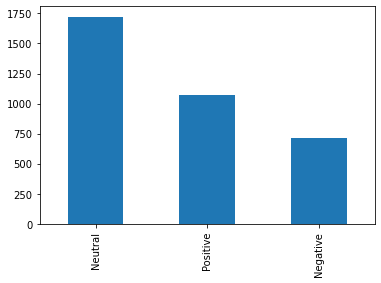

In [41]:
final_data_compB.Sentiment2.value_counts().plot.bar()

In [42]:
final_data_compB.Sentiment2.value_counts()

Neutral     1721
Positive    1070
Negative     710
Name: Sentiment2, dtype: int64

Company B: Overall sentiments on the tweets -
* Neutral - 49.15%
* Positive - 30.56%
* Negative - 20.27%


##### On Competitor Data: Company C

In [43]:
final_data_compC = check_sentiments(data_compC)

In [44]:
final_data_compC.head()

,text,polarity,Sentiment,Sentiment2
0,still getting still taking action already comp...,-0.10,Negative,Negative
1,sure reference citation technology rely turn g...,0.25,Positive,Positive
2,engineer see shopping,0.00,Positive,Neutral
3,image offer background great discount bulk ord...,0.80,Positive,Positive
4,order copy book compilation heart touching mot...,0.50,Positive,Positive


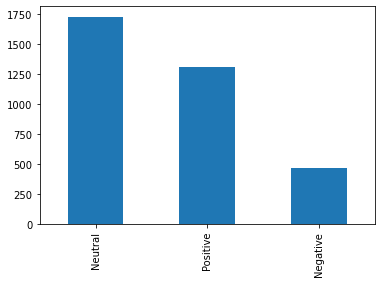

In [45]:
final_data_compC.Sentiment2.value_counts().plot.bar()

In [46]:
final_data_compC.Sentiment2.value_counts()

Neutral     1726
Positive    1308
Negative     467
Name: Sentiment2, dtype: int64

Company C: Overall sentiments on the tweets -
* Neutral = 49.3%
* Positive = 37.36%
* Negative = 13.33%

##### Analysis based on 3500 tweets extracted for all the competitors -
1. All the three competitors have received almost similar neutral opinions.
2. The most negative sentiment (amongst all the 3 competitors) is received by - CompanyB (at 20.27%).
As per the data, it could be due to - Fake orders, refund issue, customer service, delivery etc. being the most frequent words in the tweets.
3. Company A has received most positive views (amongst the 3 competitors - at 39.36%) - due to discounts, offers, which were also given on books. 
4. Amongst Company B and Company C, Company C is doing slightly better (at 37.36% > 30.56% as positive sentiments). This could be due to customer service, products, etc.
